# Kaggle Notebook & Presentation
# Expedia Hotel Recommendations

Group Members: Sarah Herman, Sarah Fodor, Isa Kashi, Charlee Stefanski, Sophia Ryan

## Statement of Purpose:

The goal of this Kaggle competition was to develop a model that provides a predicition of what hotel type an Expedia customer will book given features such as destination, number of children, length of stay, etc. 

We sought to explore the Expedia consumer data through visualizations first to make predictions on which variables will be the most significant, then use clustering and clasification techniques to confirm what we saw in our visualizations.

## Step 1: Data Exploration & Visualization

### Cleaning Data

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import all necessary packages
# pandas
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from datetime import date

import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd

from sklearn import metrics
import os

/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
# Bokeh import statements
from bokeh.layouts import layout
from bokeh.layouts import widgetbox

from bokeh.embed import file_html

from bokeh.io import show
from bokeh.io import output_notebook

from bokeh.models import Text
from bokeh.models import Plot
from bokeh.models import Title
from bokeh.models import Slider
from bokeh.models import Circle
from bokeh.models import Range1d
from bokeh.models import CustomJS
from bokeh.models import HoverTool
from bokeh.models import LinearAxis
from bokeh.models import ColumnDataSource
from bokeh.models import SingleIntervalTicker
from bokeh.plotting import figure
from bokeh.palettes import plasma

In [4]:
# Read in expedia & test csv files as a DataFrame
train_df = pd.read_csv('train.csv')
# test_df    = pd.read_csv('test.csv', nrows=2500000)
destination = pd.read_csv('destinations.csv')

In [57]:
# Remove users that do not book a hotel
bookings_df = train_df[train_df["is_booking"] == 1]

In [58]:
# Drop the columns "is_booking" as they all should be removed already
bookings_df = bookings_df.dropna()
bookings_df = bookings_df.drop(columns=['is_booking'])

### Visualizations

#### First Visualization

In [59]:
# Open Bokeh Notebook
output_notebook()

Loading BokehJS ...

In [60]:
## Creating a new Bokeh Graph to see # of bookings per cluster
# Create new dataframe with hotel_clusters & cnt, grouping by hotel_cluster #
graph_df = bookings_df.groupby(["hotel_cluster"])["cnt"].count()
# Reset index
graph_df = graph_df.to_frame().reset_index()

In [61]:
# Bokeh visualization code
select_tools = ['box_select', 'lasso_select', 'poly_select', 'tap', 'reset']
p = figure(y_range = (0,130000), 
           x_range = (1,100),
           plot_height=650,
           plot_width=700,
           x_axis_label='Cluster #',
           y_axis_label='# of Bookings in Cluster',
           title='''Number of bookings per cluster''',
          )

p.vbar(x='hotel_cluster', top='cnt', width=1, 
       source = graph_df, line_color= "black", hover_color="black")
p.xaxis.major_label_orientation = 1.5

tooltips = [
            ('Hotel Cluster','@hotel_cluster'),
            ('# of bookings per cluster','@cnt')
            ]

# Add the HoverTool to the figure
p.add_tools(HoverTool(tooltips=tooltips))

# Show graph
show(p)

#### Visualization Explanation:

In order to understand the variable we were trying to predict, we plotted the distribution of the number of times the hotel was booked in our dataset. Looking at this visualization we realized that there is a large distribution between the amount of bookings in each cluster. 

Moving forward, we took this into account in our multiple different attempts to improve the accuracy score. We experimented with removing the clusters that had not been booked more than 30,000 times. That code is below.

#### Second Visualization

In [62]:
# Make a new dataframe so code resets
feat_df = bookings_df.copy()
# Create a cluster count
cluster_count = feat_df['hotel_cluster'].value_counts()
# Only take clusters with 30,000 searches or more
cluster_count = cluster_count[cluster_count >= 30000]
# Creates a list 
cluster_list = cluster_count.index.tolist()

In [63]:
# New dataframe that only contains clusters that are greater than 30000
feat_df = feat_df[feat_df['hotel_cluster'].isin(cluster_list)]

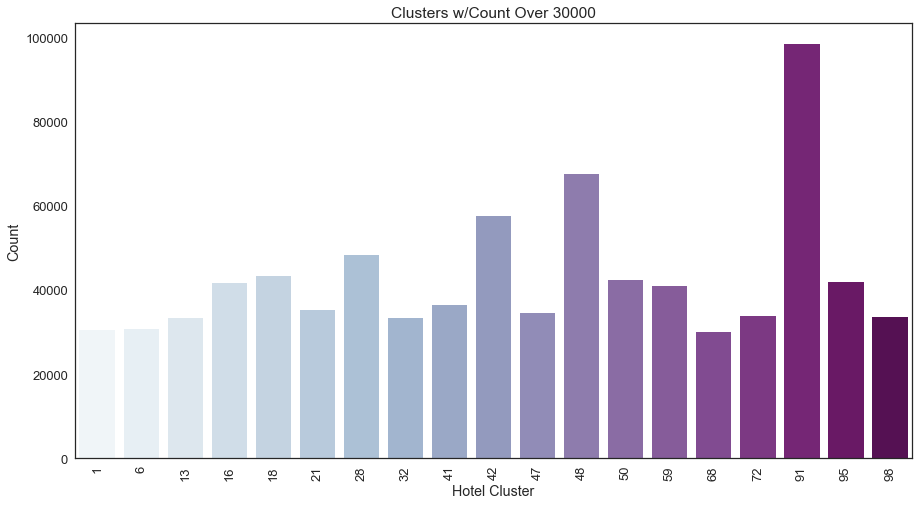

In [64]:
plt.figure(figsize = (15,8))
sns.countplot(data=feat_df, x="hotel_cluster", palette='BuPu');
plt.xticks(rotation = 'vertical');
plt.xlabel('Hotel Cluster');
plt.ylabel('Count');
plt.title("Clusters w/Count Over 30000");

#### Visualization Explanation:

This visualization shows us that after removing the clusters that did not have 30,000 bookings, the distribution is much more evenly distributed. In future code, we thought this would increase our accuracy score. We will see if that statement proves true below.

## Step 2: Engineer features and visualize them

In [65]:
# Dropping user location region and user location city 
# because they have too many unique values
bookings_df = bookings_df.drop(columns = ['user_location_region','user_location_city'])

In [66]:
# Dropping user ID because it doesn't add value to the model
bookings_df = bookings_df.drop(columns = ['user_id'])

In [67]:
# Make a copy of the dataframe to not confuse
feat_df = bookings_df.copy()

### New Feature #1: Length Of Stay

We thought that the length of one's stay could be indicative of where they were staying as people vacationing for have longer stays and people traveling for business would have shorter stays.

In [68]:
# Create new variable for the length of stay in using 
# check in time and checkout time
feat_df['length_of_stay'] = pd.to_datetime(feat_df['srch_co']) - pd.to_datetime(feat_df['srch_ci'])
feat_df['length_of_stay'] = feat_df['length_of_stay'].dt.days

In [69]:
# Drop all the rows where length of stay is less than 1 
# because that means there is an error in the data entry
feat_df = feat_df.drop(feat_df[feat_df.length_of_stay < 1].index)

##### Visualization of length of stay

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


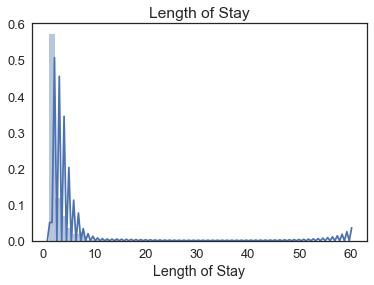

In [70]:
sns.distplot(feat_df['length_of_stay']);
plt.xlabel('Length of Stay');
plt.title("Length of Stay");

### New Feature #2: Has children

We thought it would be interesting to see if a user has children or not and whether that would impact the hotel cluster. We decided to use bianary variable: 0=false, 1=true

In [71]:
# Create a binary value for whether or not the user has children
feat_df['has_kids'] = np.where(feat_df.srch_children_cnt > 0, 1, 0)

##### Visualization of bookers who have children vs those who don't

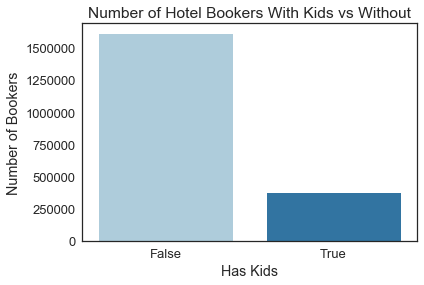

In [72]:
current_palette = sns.color_palette("Paired")
sns.countplot(x="has_kids", data=feat_df, palette = current_palette).set_title("Number of Hotel Bookers With Kids vs Without")
plt.xlabel('Has Kids')
plt.ylabel('Number of Bookers')
labels = ('False', 'True')
positions = (0, 1)
plt.xticks(positions, labels);

### New Feature #3: Books More Than One Room

Similarly to whether a user has children we thought it would be interesting to see whether the number of rooms books has any importance in our model. Again we used bianary variables where 0=False, 1=True

In [73]:
# Create a binary value for whether or not the user 
# is looking to book multiple rooms or just one
feat_df['multiple_rooms'] = np.where(feat_df.srch_rm_cnt > 1, 1, 0)

##### Visualization  whether user booked more than one room or not

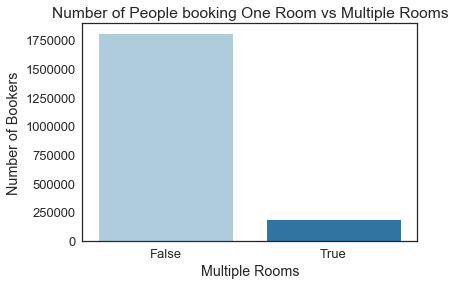

In [74]:
sns.countplot(x="multiple_rooms", data=feat_df, palette=current_palette).set_title("Number of People booking One Room vs Multiple Rooms")
plt.xlabel('Multiple Rooms')
plt.ylabel('Number of Bookers')
labels = ('False', 'True')
positions = (0, 1)
plt.xticks(positions, labels);

#### New Feature #4: Length of Time Between Booking and Checkin

In [75]:
# Create a new feature for length of time between making 
# the booking and the checkin date
feat_df['booking_to_chkin'] = pd.to_datetime(feat_df['srch_ci']) - pd.to_datetime(feat_df['date_time'])
feat_df['booking_to_chkin'] = feat_df['booking_to_chkin'].dt.days

In [76]:
# Drop all the rows where length of stay is less than 
# 0 because that means there is an error in the data entry
feat_df = feat_df.drop(feat_df[feat_df.booking_to_chkin < 0].index)

In [77]:
# Seperate booking_to_chkin into 4 bins, 
# one being zero or one for quick reservations, 
# 6 weeks or less, and then greater
bins = [0,1,42,1000000000]
dummies = pd.get_dummies(pd.cut(feat_df['booking_to_chkin'],bins,labels=['booked_days_before','booked_weeks_before','booked_months_before']))
feat_df = pd.concat([feat_df,dummies],axis="columns")

#### New Features #5: Is the search country the same as destination country?

In [78]:
# Make binary value for if hotel continent and user_location_country
feat_df['same_country'] = np.where(feat_df.user_location_country == feat_df.hotel_country,1,0)

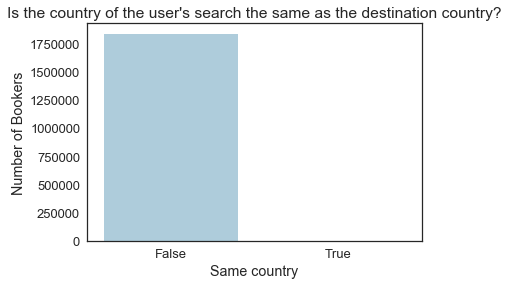

In [79]:
sns.countplot(x="same_country", data=feat_df, palette=current_palette).set_title("Is the country of the user's search the same as the destination country?")
plt.xlabel('Same country')
plt.ylabel('Number of Bookers')
labels = ('False', 'True')
positions = (0, 1)
plt.xticks(positions, labels);

#### New Feature #6: Bins for search to destination distance

In [80]:
# Seperate search to destination into bins
bins = [0,100,4000,1000000000]
dummies = pd.get_dummies(pd.cut(feat_df['orig_destination_distance'],bins,labels=['dest_close','dest_far','dest_very_far']))
feat_df = pd.concat([feat_df,dummies],axis="columns")

In [81]:
# Dropping columns that are no longer needed
feat_df = feat_df.drop(columns = ['date_time','srch_ci','srch_co'])

### Heatmap of correlations between all of the variable

Our final attempt to understand the data was to create a visualization, including all new variables, to see if there were any super high correlations between two variables and between "hotel_cluster" and any single variable.

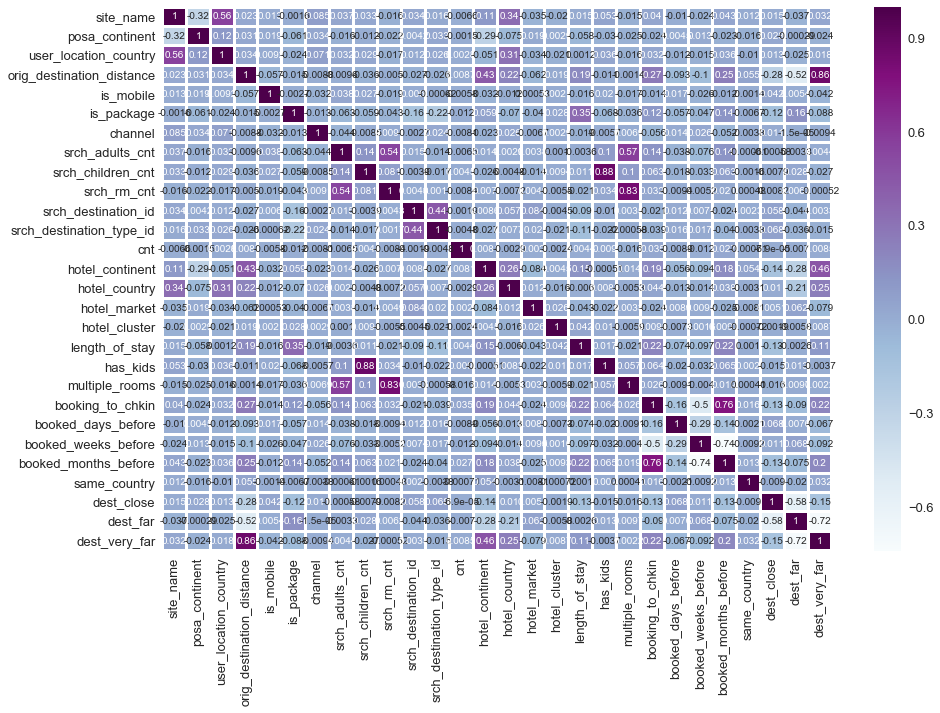

In [82]:
# Heatmap code
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(feat_df.corr(),cmap='BuPu',ax=ax,annot=True,linewidths=2);

As you can see from this model, there aren't two variables that have super strong correlation besides two variables  with themselves. Additionally, there isn't a variable that has strong correlation with "hotel_cluster" variable, which showed us we might have difficulties predicting the cluster in our models.

## Step 3: Building the Model

As seen above, we thought it might be hard to predict our cluster. We tried various different attempts at building a successful predictive model as can be seen below.

### Attempt  #1: Run model with only features which have less than 100 unique values

In [33]:
model_df_refined = feat_df[['site_name', 'posa_continent', 'user_location_country', 'is_mobile',
       'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt','srch_destination_type_id', 'cnt',
       'hotel_continent', 'hotel_country','hotel_cluster',
       'length_of_stay', 'has_kids', 'multiple_rooms','booked_days_before', 'booked_weeks_before', 'booked_months_before',
       'same_country', 'dest_close', 'dest_far', 'dest_very_far']]

In [34]:
target = "hotel_cluster"

X = model_df_refined.drop(target,1)
y = model_df_refined[target]

seed=7

test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [35]:
model = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    random_state=seed,
    max_depth=None,
    min_samples_split=2)

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [36]:
y_pred = model.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score
# evaluate predictions
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 7.81%


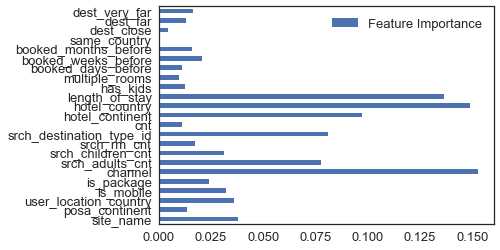

In [38]:
# Check feature importance
feat_importance = model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
             index=list(X)).plot(kind='barh');

### Limit the hotel clusters to only the most popular ones

In [83]:
#cut down data to most common clusters
cluster_count = feat_df['hotel_cluster'].value_counts()
cluster_count = cluster_count[cluster_count >= 30000]
cluster_list = cluster_count.index.tolist()
cluster_list

[91, 48, 42, 28, 18, 95, 59, 16, 50, 41, 21, 98, 72, 13]

In [84]:
feat_df = feat_df[feat_df['hotel_cluster'].isin(cluster_list)]
feat_df.shape

(597818, 28)

### Attempt #2: Run again with all features

In [85]:
rf_df = feat_df.copy()

In [86]:
#remember to explain why we didn't use their test dataset
target = "hotel_cluster"

X = rf_df.drop(target,1)
y = rf_df[target]

seed=7

test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [87]:
model = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    random_state=seed,
    max_depth=None,
    min_samples_split=2)

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [88]:
y_pred = model.predict(X_test)

In [89]:
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 28.71%


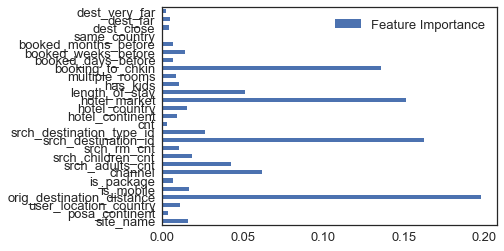

In [90]:
# Check feature importance
feat_importance = model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
             index=list(X)).plot(kind='barh');

### Attempt #3: Run again with only high feature importance

In [108]:
rf_df_revised = feat_df[['booking_to_chkin','length_of_stay',
                         'srch_destination_id','srch_adults_cnt','srch_children_cnt',
                         'channel','hotel_market','hotel_cluster','orig_destination_distance']]

In [109]:
#remember to explain why we didn't use their test dataset
target = "hotel_cluster"

X = rf_df_revised.drop(target,1)
y = rf_df_revised[target]

seed=7

test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [110]:
model = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    random_state=seed,
    max_depth=None,
    min_samples_split=2)

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [111]:
y_pred = model.predict(X_test)

In [112]:
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 27.30%


### Attempt #4: Predict using only specific variables

In [120]:
revised_df = feat_df[['site_name', 'posa_continent', 'user_location_country',
       'orig_destination_distance', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster','length_of_stay','booking_to_chkin']]

In [122]:
#remember to explain why we didn't use their test dataset
target = "hotel_cluster"

X = revised_df.drop(target,1)
y = revised_df[target]

seed=7

test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [123]:
model = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    random_state=seed,
    max_depth=None,
    min_samples_split=2)

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [124]:
y_pred = model.predict(X_test)

In [125]:
# evaluate predictions
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 30.61%


### Attempt #5: Run pipeline for best model

In [126]:
y = revised_df['hotel_cluster']
X = revised_df.drop(['hotel_cluster'],axis=1)

In [127]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [129]:
numeric_features = revised_df.select_dtypes(include=['int64', 'uint8','float64']).drop('hotel_cluster',axis=1).columns
categorical_features = revised_df.select_dtypes(include=['object']).columns
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [130]:
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=100))])

In [131]:
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [132]:
accuracy = rf.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 31.87%


# Challenges and Limitations

After several attempts at building a successful model, we could not get the accuracy score above 32%. We believe that this was due to both limitations in the data set and possibly insufficient feature engineering. The data provided on Kaggle from Expedia included only data that is imputted by the user upon their search. This means that there is no data about the user's preferences, income, or previous bookings. Furthermore, you can see what hotel cluster they booked, but no more information about the type of accomodation or number of room they booked. However, we did hope to still be able to create a more accurate model. However, after running dozens of variations (we only chose the most descriptive ones for this notebook), as well as additional brainstorming and research, we could not think of any more ideas for improving the model.

# Future Work

Our reccomendations for future work would be to revisit the feature engineering, and potentially compare it to other notebooks on Kaggle. We did our feature engineering based on what we thought would be most logical considering the data set, but it is possible there are better ideas we had not considered. Furthermore, this project could potentially benefit from more focus on clustering to gain a better understanding of the data and its correlations between variables, which would hopefully lead to creating a more accurate model.